In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# MICCAI 2023 simulation experiment

In [3]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023'

In [69]:
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --noise_ratio {noise_ratio} \\
    --omega {omega} \\
    --n_layers {n_layers} \\
    --activ_fn {activ_fn} \\
    --polar_input {polar_input} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{noise_ratio:.0e}_{savgol_filter}_{omega}_{pde_name}'

param_space = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    noise_ratio=[0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    omega=[60],
    n_layers=[5],
    activ_fn=['ss'],
    savgol_filter=[0, 1],
    pde_name=['helmholtz', 'hetero'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)

len(param_space)

144

In [67]:
name.format(**list(param_space)[0])

'train_fem_box_50_0e+00_0_30_helmholtz'

In [68]:
%autoreload

expt_name = '2023-2-24_sim_noise2'

jobs = ps.submit(template, name, list(param_space)[:2], work_dir=expt_name, verbose=True)
jobs.to_csv(f'{expt_name}.jobs')

#jobs = pd.read_csv(f'{expt_name}.jobs')

100%|██████████| 2/2 [00:00<00:00,  4.25it/s]
[14688798, 14688799]


In [40]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs, parse=True)[status_cols]
status

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
14679319,train_fem_box_50_0e+00_5_ss_helmholtz,NaN,NaN,NaN,[33936 rows x 4 columns],None
14679320,train_fem_box_50_0e+00_5_ss_hetero,NaN,NaN,NaN,[33936 rows x 4 columns],None
14679321,train_fem_box_50_0e+00_5_st_helmholtz,NaN,NaN,NaN,[33936 rows x 4 columns],None
14679322,train_fem_box_50_0e+00_5_st_hetero,NaN,NaN,NaN,[33936 rows x 4 columns],None
14679323,train_fem_box_50_0e+00_10_ss_helmholtz,NaN,NaN,NaN,[33936 rows x 4 columns],None
...,...,...,...,...,...,...
14679602,train_fem_box_100_1e-01_5_st_hetero,NaN,NaN,NaN,None,/var/spool/slurm/d/job14679602/slurm_script: l...
14679603,train_fem_box_100_1e-01_10_ss_helmholtz,NaN,NaN,NaN,None,/var/spool/slurm/d/job14679603/slurm_script: l...
14679604,train_fem_box_100_1e-01_10_ss_hetero,NaN,NaN,NaN,[33936 rows x 4 columns],None


In [45]:
status['has_error'] = ~status.stderr.isnull()
status.fillna('DONE').groupby(['job_state', 'has_error'])[['job_name']].count()

job_name
job_state has_error          
DONE      False           167
          True            120
RUNNING   False             1

In [47]:
status['python_error'] = status.stderr.str.contains('python: command not found')
status.groupby(['has_error', 'python_error'])[['job_name']].count()

,,job_name
has_error,python_error,
True,True,120


In [10]:
metrics = ps.metrics(jobs)

# did all models train to completion?
#assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 100e3]

param_cols = ['pde_name', 'example_id', 'noise_ratio', 'n_layers', 'activ_fn'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric values

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
metrics = metrics.unstack(level=[len(param_cols)])

def metric_map(t):
    metric_name, var_name = t
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

train_fem_box_50_1e-03_5_ss_helmholtz No objects to concatenate
train_fem_box_50_1e-03_5_ss_hetero No objects to concatenate
train_fem_box_50_1e-03_5_st_helmholtz No objects to concatenate
train_fem_box_50_1e-03_5_st_hetero No objects to concatenate
train_fem_box_50_1e-03_10_ss_helmholtz No objects to concatenate
train_fem_box_50_1e-03_10_ss_hetero No objects to concatenate
train_fem_box_50_1e-03_10_st_helmholtz No objects to concatenate
train_fem_box_50_1e-03_10_st_hetero No objects to concatenate
train_fem_box_50_1e-02_5_ss_helmholtz No objects to concatenate
train_fem_box_50_1e-02_5_ss_hetero No objects to concatenate
train_fem_box_50_1e-02_5_st_helmholtz No objects to concatenate
train_fem_box_50_1e-02_5_st_hetero No objects to concatenate
train_fem_box_50_1e-02_10_ss_helmholtz No objects to concatenate
train_fem_box_50_1e-02_10_ss_hetero No objects to concatenate
train_fem_box_50_1e-02_10_st_helmholtz No objects to concatenate
train_fem_box_50_1e-02_10_st_hetero No objects to conc

a_pred_MSAV  \
pde_name  example_id noise_ratio n_layers activ_fn spatial_frequency_bin spatial_region                
helmholtz 50         0.000       5        ss       all                   all                     0.0   
                                                                         1                       NaN   
                                                                         2                       NaN   
                                                                         3                       NaN   
                                                                         4                       NaN   
...                                                                                              ...   
hetero    100        0.001       10       ss       6.0                   all                     NaN   
                                                   7.0                   all                     NaN   
                                                   8.0                   all                     NaN   
                                                   9.0                   all                     NaN   
                                                   10.0                  all                     NaN   

                                                                                         a_pred_MSAE  \
pde_name  example_id noise_ratio n_layers activ_fn spatial_frequency_bin spatial_region                
helmholtz 50         0.000       5        ss       all                   all                     0.0   
                                                                         1                       NaN   
                                                                         2                       NaN   
                                                                         3                       NaN   
                                                                         4                       NaN   
...                                                                                              ...   
hetero    100        0.001       10       ss       6.0                   all                     NaN   
                                                   7.0                   all                     NaN   
                                                   8.0                   all                     NaN   
                                                   9.0                   all                     NaN   
                                                   10.0                  all                     NaN   

                                                                                         a_true_MSAV  \
pde_name  example_id noise_ratio n_layers activ_fn spatial_frequency_bin spatial_region                
helmholtz 50         0.000       5        ss       all                   all                     0.0   
                                                                         1                       NaN   
                                                                         2                       NaN   
                                                                         3                       NaN   
                                                                         4                       NaN   
...                                                                                              ...   
hetero    100        0.001       10       ss       6.0                   all                     NaN   
                                                   7.0                   all                     NaN   
                                                   8.0                   all                     NaN   
                                                   9.0                   all                     NaN   
                                                   10.0                  all                     NaN   

                              

<IPython.core.display.Javascript object>


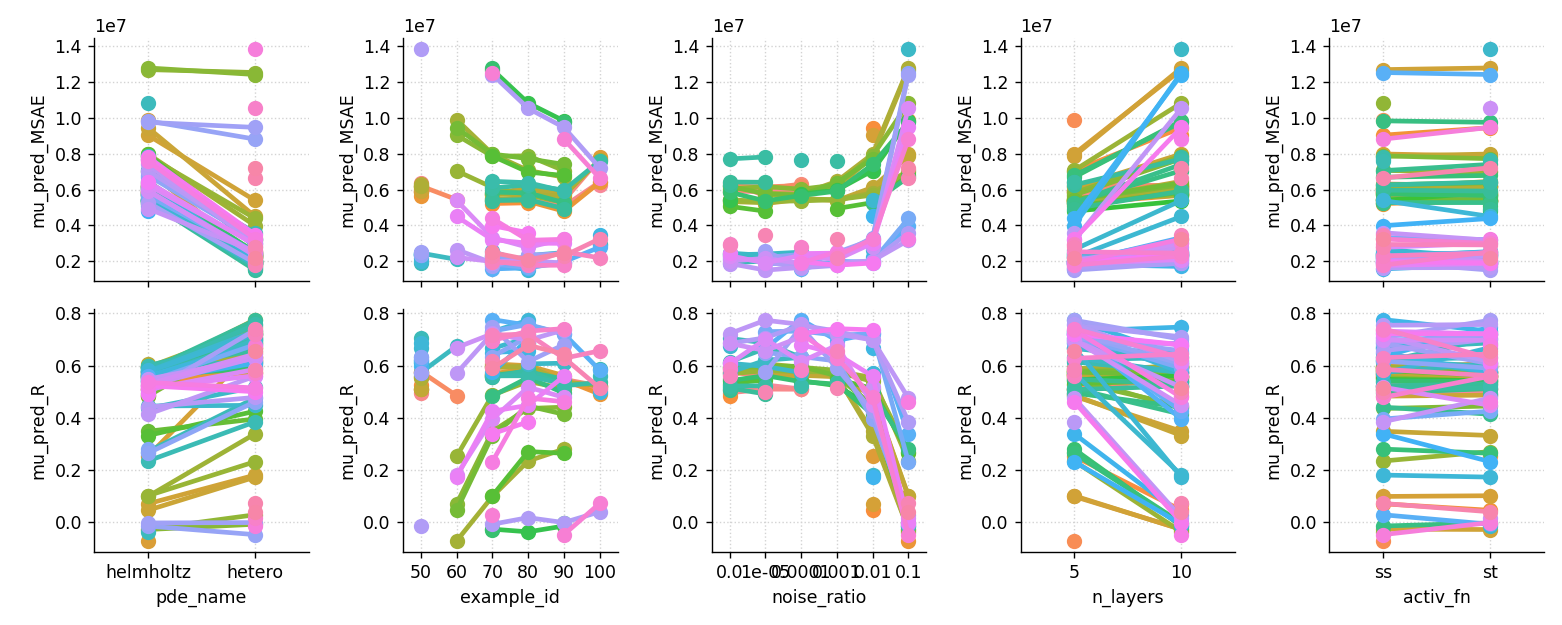

In [12]:
m = metrics.reset_index()

fig = ps.plot(
    m[(m.spatial_region == 'all') & (m.spatial_frequency_bin == 'all')].copy(),
    x=param_cols,
    y=['mu_pred_MSAE', 'mu_pred_R'],
    height=2.5,
    width=2.5,
    legend=False,
    tight=True
)

In [15]:
m['method'] = 'PINN_' + m['pde_name']

direct_helmholtz_m = m[m.pde_name == 'helmholtz'].copy()
direct_helmholtz_m['method'] = 'direct_helmholtz'
for col in m.columns:
    if col.startswith('direct'):
        direct_helmholtz_m[col.replace('direct', 'mu')] = m[col]

fem_helmholtz_m = m[m.pde_name == 'helmholtz'].copy()
fem_helmholtz_m['method'] = 'FEM_helmholtz'
for col in m.columns:
    if col.startswith('fem'):
        fem_helmholtz_m[col.replace('fem', 'mu')] = m[col]
        
fem_hetero_m = m[m.pde_name == 'hetero'].copy()
fem_hetero_m['method'] = 'FEM_hetero'
for col in m.columns:
    if col.startswith('fem'):
        fem_hetero_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([direct_helmholtz_m, fem_helmholtz_m, fem_hetero_m, m])

In [16]:
import matplotlib as mpl
pct_format = mpl.ticker.PercentFormatter()

mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV'] * 100
mm['mu_pred_MAD_relative'] = mm['mu_pred_MAD'] / mm['mu_true_MAV'] * 100

In [17]:
%autoreload
import seaborn as sns
import matplotlib.pyplot as plt

colors = ps.results.get_color_palette(10, type='deep', min_val=0)
blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = colors

colors = [red, yellow, green, cyan, blue]
sns.set_palette(colors)
colors = sns.color_palette()
colors

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

<IPython.core.display.Javascript object>


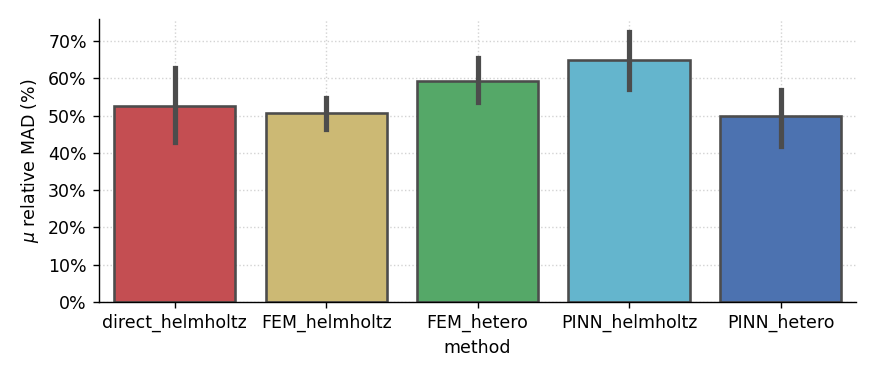

In [20]:
import matplotlib as mpl

fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0) & (mm.n_layers == 5)].copy(),
    x='method',
    hue='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=7,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_method_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


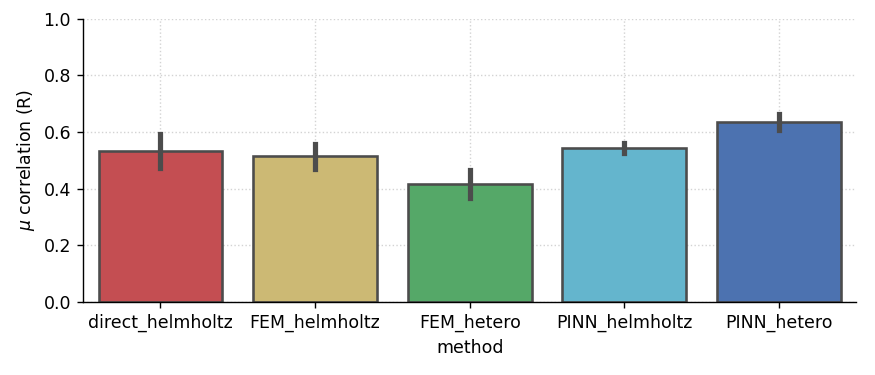

In [21]:
fig = ps.plot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all') & (mm.noise_ratio == 0.0)].copy(),
    x='method',
    hue='method',
    y='mu_pred_R',
    height=3,
    width=7,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_ylim([0, 1])

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_method_R_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


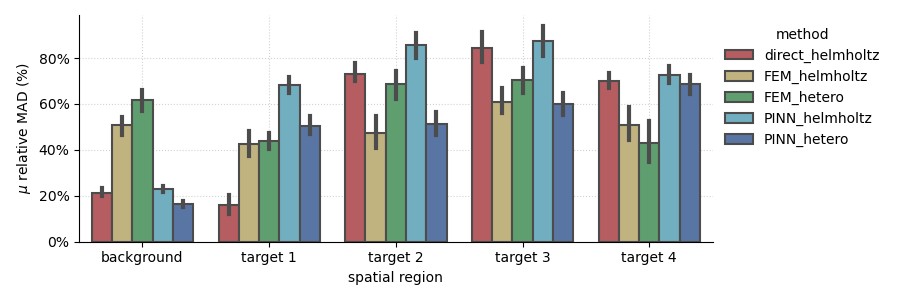

In [48]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

fig.axes[0].set_xlabel('spatial region')
fig.axes[0].set_xticklabels(['background', 'target 1', 'target 2', 'target 3', 'target 4'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_region_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


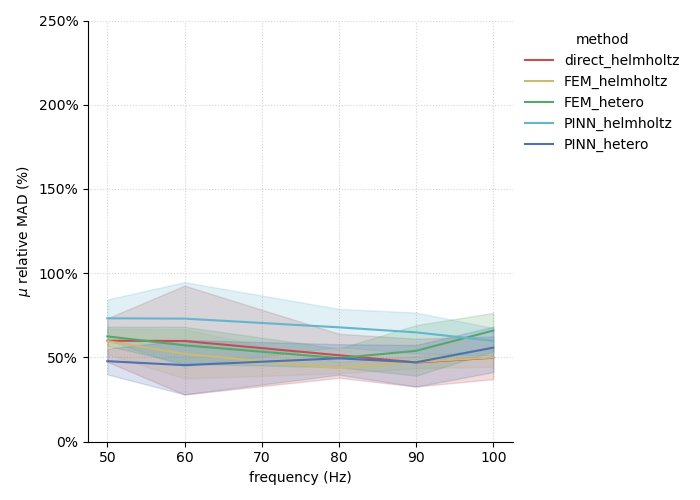

In [49]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)],
    x='example_id',
    y='mu_pred_MAD_relative',
    hue='method',
    height=5,
    width=7,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 250)
fig.tight_layout()

fig.axes[0].set_xlabel('frequency (Hz)')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_frequency_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [50]:
mm['noise_level'] = 10 * np.log10(mm['noise_ratio'])
mm['noise_level'][np.isinf(mm.noise_level)] = -60
mm['noise_level']

  result = getattr(ufunc, method)(*inputs, **kwargs)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mm['noise_level'][np.isinf(mm.noise_level)] = -60



0      -60.0
1      -60.0
2      -60.0
3      -60.0
4      -60.0
        ... 
2667   -30.0
2668   -30.0
2669   -30.0
2670   -30.0
2671   -30.0
Name: noise_level, Length: 6704, dtype: float64

<IPython.core.display.Javascript object>


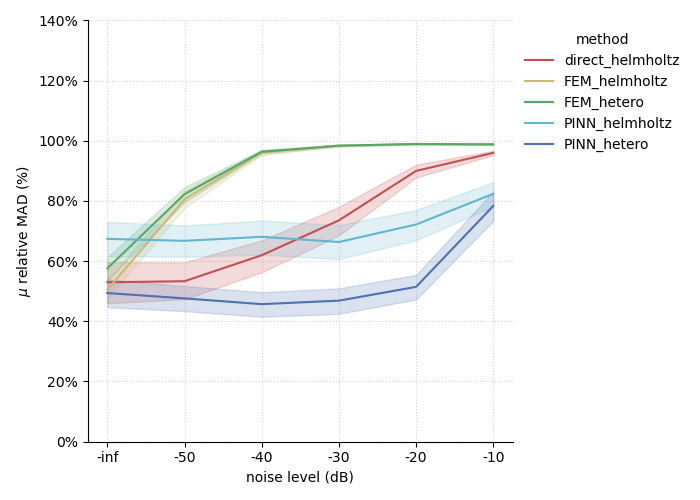

In [51]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all')],
    x='noise_level',
    y='mu_pred_MAD_relative',
    hue='method',
    height=5,
    width=7,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.axes[0].set_ylim(0, 140)
fig.tight_layout()

fig.axes[0].set_xlabel('noise level (dB)')
fig.axes[0].set_xticks([-60, -50, -40, -30, -20, -10])
fig.axes[0].set_xticklabels(['-inf', '-50', '-40', '-30', '-20', '-10'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_noise_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [52]:
%autoreload

blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = sns.color_palette('tab10')

mre_pinn.visual.COLORS.update(
    red=red,
    yellow=yellow,
    green=green,
    cyan=cyan,
    blue=blue
)

Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc


<IPython.core.display.Javascript object>


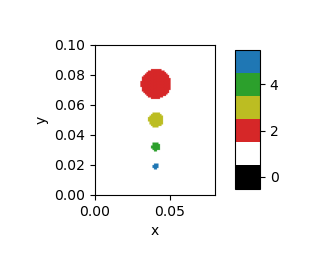

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



<IPython.core.display.Javascript object>


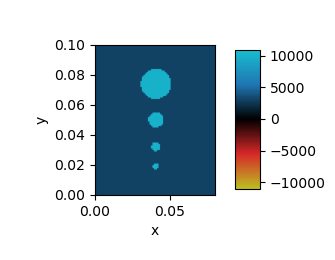

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



In [53]:
dataset = mre_pinn.data.MREDataset.load_xarrays(
    xarray_dir='../data/BIOQIC/fem_box'
)
dataset[0].view('mre_mask', ax_height=1.5, space=0.2)
plt.gcf().tight_layout()
plt.savefig('images/fem_box_regions.png', dpi=200, bbox_inches='tight')
dataset[0].view('mre', ax_height=1.5, space=0.2)
plt.gcf().tight_layout()
plt.savefig('images/fem_box_mre.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


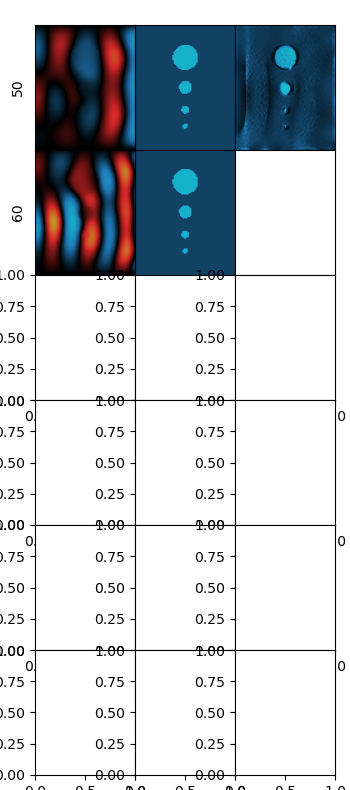

Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-2-24_sim_noise/train_fem_box_50_0e+00_5_ss_helmholtz/train_fem_box_50_0e+00_5_ss_helmholtz_direct.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading 2022-2-24_sim_noise/train_fem_box_60_0e+00_5_ss_helmholtz/train_fem_box_60_0e+00_5_ss_helmholtz_direct.nc


FileNotFoundError: [Errno 2] No such file or directory: b'/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023/2022-2-24_sim_noise/train_fem_box_60_0e+00_5_ss_helmholtz/train_fem_box_60_0e+00_5_ss_helmholtz_direct.nc'

In [57]:
%autoreload
import mre_pinn

# data grid

image_names = ['wave image', 'elastogram', 'direct_helmholtz']

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    
    data_name = 'fem_box'
    noise_ratio = 0.0
    n_layers = 5
    activ_fn = 'ss'

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(example_id, fontsize='medium')
            if row_idx == 0 and False:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])
            
            if image_name == 'regions':
                array = example.mre_mask.sel(z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)

            elif image_name == 'wave image':
                array = example.wave.sel(component='z', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = array.real

            elif image_name in {'ground truth', 'elastogram'}:
                array = example.mre.sel(z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'direct_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, n_layers=n_layers, activ_fn=activ_fn
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)
                
            elif image_name == 'FEM_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, n_layers=n_layers, activ_fn=activ_fn
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio, n_layers=n_layers, activ_fn=activ_fn
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio, n_layers=n_layers, activ_fn=activ_fn
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array, **color_kws)
            
    return fig

fig = plot_image_grid(['50', '60', '70', '80', '90', '100'])
fig0 = plot_image_grid(['50', '60', '70'])
fig1 = plot_image_grid(['80', '90', '100'])

for ext in ['png', 'pdf']:
    #fig.savefig(f'images/fem_box_wave_grid.{ext}', bbox_inches='tight', dpi=200)
    fig0.savefig(f'images/fem_box_wave_grid0.{ext}', bbox_inches='tight', dpi=200)
    fig1.savefig(f'images/fem_box_wave_grid1.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


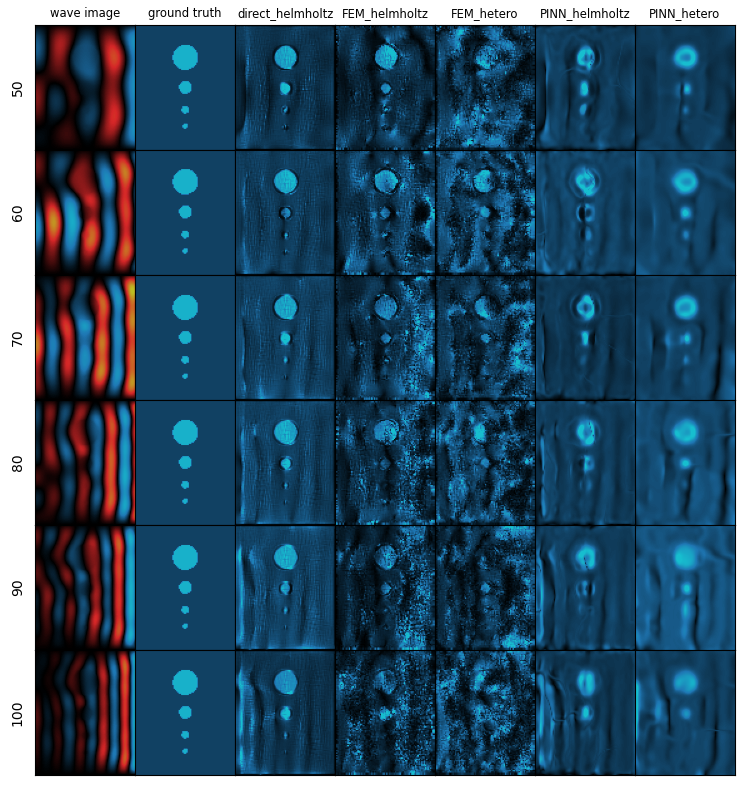

Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_helmholtz/train_fem_box_50_0e+00_helmholtz_direct.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_helmholtz/train_fem_box_50_0e+00_helmholtz_fem.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_hetero/train_fem_box_50_0e+00_hetero_fem.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_helmholtz/train_fem_box_50_0e+00_helmholtz_elastogram.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_hetero/train_fem_box_50_0e+00_hetero_elastogram.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_60_0e+00_helmholtz/train_fem_box_60_0e+00_helmholtz_direct.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_60_0e+00_helmholtz/train_fem_box_60_0e+00_helmholtz_fem.nc

In [13]:
%autoreload
import mre_pinn

image_names = ['wave image', 'ground truth', 'direct_helmholtz', 'FEM_helmholtz', 'FEM_hetero', 'PINN_helmholtz', 'PINN_hetero']

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    
    data_name = 'fem_box'
    noise_ratio = 0.0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(example_id, fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave.sel(component='z', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = array.real

            elif image_name == 'ground truth':
                array = example.mre.sel(z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'direct_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)
                
            elif image_name == 'FEM_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array, **color_kws)
            
    return fig

fig = plot_image_grid(['50', '60', '70', '80', '90', '100'])
#fig0 = plot_image_grid(['50', '60', '70'])
#fig1 = plot_image_grid(['80', '90', '100'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_example_grid.{ext}', bbox_inches='tight', dpi=200)
    #fig0.savefig(f'images/fem_box_example_grid0.{ext}', bbox_inches='tight', dpi=200)
    #fig1.savefig(f'images/fem_box_example_grid1.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


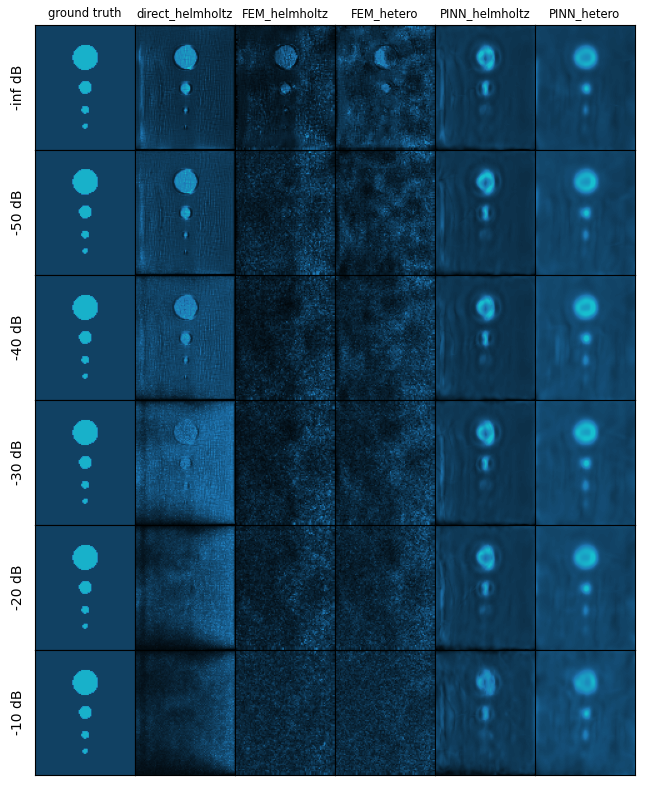

  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)



Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc


  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)



Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Load

Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_1e-03_helmholtz/train_fem_box_80_1e-03_helmholtz_direct.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_1e-03_helmholtz/train_fem_box_90_1e-03_helmholtz_direct.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_100_1e-03_helmholtz/train_fem_box_100_1e-03_helmholtz_direct.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_1e-02_helmholtz/train_fem_box_50_1e-02_helmholtz_direct.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loadi

Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_100_1e-03_helmholtz/train_fem_box_100_1e-03_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_1e-02_helmholtz/train_fem_box_50_1e-02_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_60_1e-02_helmholtz/train_fem_box_60_1e-02_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_70_1e-02_helmholtz/train_fem_box_70_1e-02_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/B

Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_1e-02_hetero/train_fem_box_80_1e-02_hetero_fem.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_1e-02_hetero/train_fem_box_90_1e-02_hetero_fem.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_100_1e-02_hetero/train_fem_box_100_1e-02_hetero_fem.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_1e-01_hetero/train_fem_box_50_1e-01_hetero_fem.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc


Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_100_1e-02_helmholtz/train_fem_box_100_1e-02_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_1e-01_helmholtz/train_fem_box_50_1e-01_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_60_1e-01_helmholtz/train_fem_box_60_1e-01_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_70_1e-01_helmholtz/train_fem_box_70_1e-01_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/8

Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_70_1e-01_hetero/train_fem_box_70_1e-01_hetero_elastogram.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_1e-01_hetero/train_fem_box_80_1e-01_hetero_elastogram.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_1e-01_hetero/train_fem_box_90_1e-01_hetero_elastogram.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_100_1e-01_hetero/train_fem_box_100_1e-01_hetero_elastogram.nc


<IPython.core.display.Javascript object>


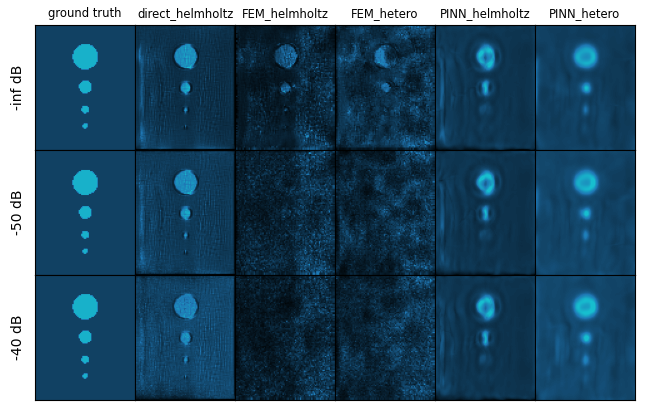

Loading ../data/BIOQIC/fem_box/50/wave.nc


  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)

  noise_level = 10 * np.log10(noise_ratio)



Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading

Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_1e-05_helmholtz/train_fem_box_80_1e-05_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_1e-05_helmholtz/train_fem_box_90_1e-05_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_100_1e-05_helmholtz/train_fem_box_100_1e-05_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_1e-04_helmholtz/train_fem_box_50_1e-04_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/B

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_60_1e-04_helmholtz/train_fem_box_60_1e-04_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_70_1e-04_helmholtz/train_fem_box_70_1e-04_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_1e-04_helmholtz/train_fem_box_80_1e-04_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_1e-04_helmholtz/train_fem_box_90_1e-04_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/100/w

<IPython.core.display.Javascript object>


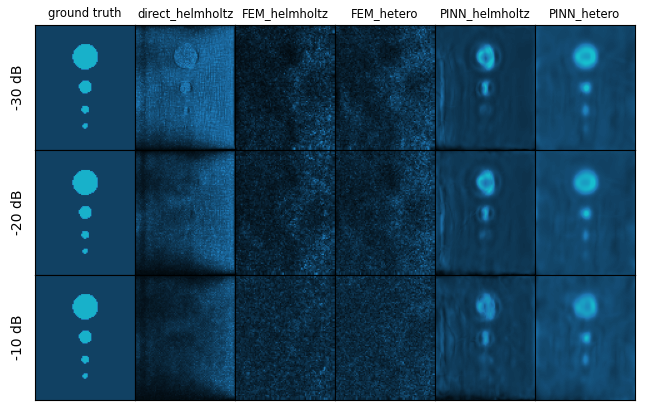

Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../

Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_1e-02_helmholtz/train_fem_box_80_1e-02_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_1e-02_helmholtz/train_fem_box_90_1e-02_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/mre.nc
Loading ../data/BIOQIC/fem_box/100/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_100_1e-02_helmholtz/train_fem_box_100_1e-02_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_1e-01_helmholtz/train_fem_box_50_1e-01_helmholtz_fem.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BI

Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_60_1e-01_helmholtz/train_fem_box_60_1e-01_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/70/wave.nc
Loading ../data/BIOQIC/fem_box/70/mre.nc
Loading ../data/BIOQIC/fem_box/70/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_70_1e-01_helmholtz/train_fem_box_70_1e-01_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_1e-01_helmholtz/train_fem_box_80_1e-01_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_1e-01_helmholtz/train_fem_box_90_1e-01_helmholtz_elastogram.nc
Loading ../data/BIOQIC/fem_box/100/wave.nc
Loading ../data/BIOQIC/fem_box/100/

In [53]:
%autoreload
import mre_pinn

# multifrequency

image_names = [
    'ground truth',
    'direct_helmholtz',
    'FEM_helmholtz',
    'FEM_hetero',
    'PINN_helmholtz',
    'PINN_hetero'
]

def plot_image_grid(example_ids, noise_ratios):
    n_rows = len(noise_ratios)
    n_cols = len(image_names)
    ax_width = 1
    ax_height = ax_width / 0.8
    
    data_name = 'fem_box'
    noise_ratio = 0.0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for col_idx, image_name in enumerate(image_names):
        for row_idx, noise_ratio in enumerate(noise_ratios):
            mean_array = 0
            for example_id in example_ids:
                example = mre_pinn.data.MREExample.load_xarrays(
                    '../data/BIOQIC/fem_box', example_id
                )
                ax = axes[row_idx,col_idx]
                #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
                if col_idx == 0:
                    noise_level = 10 * np.log10(noise_ratio)
                    ax.set_ylabel('{:.0f} dB'.format(noise_level), fontsize='medium')
                if row_idx == 0:
                    ax.set_title(image_name, fontsize='small')
                ax.set_yticks([])
                ax.set_xticks([])

                if image_name == 'wave image':
                    array = example.wave.sel(component='z', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = array.real

                elif image_name == 'ground truth':
                    array = example.mre.sel(z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'direct_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'FEM_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'FEM_hetero':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'PINN_helmholtz':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                elif image_name == 'PINN_hetero':
                    job_name = name.format(
                        data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                    )
                    nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                    array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                    color_kws = mre_pinn.visual.get_color_kws(array)
                    color_kws['vmin'] = -color_kws['vmax']
                    array = np.abs(array)

                mean_array += array / len(example_ids)

            mre_pinn.visual.imshow(ax, mean_array, **color_kws)
            
    return fig

fig = plot_image_grid(['50', '60', '70', '80', '90', '100'], [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
fig0 = plot_image_grid(['50', '60', '70', '80', '90', '100'], [0, 1e-5, 1e-4])
fig1 = plot_image_grid(['50', '60', '70', '80', '90', '100'], [1e-3, 1e-2, 1e-1])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_multifreq_grid.{ext}', bbox_inches='tight', dpi=200)
    fig0.savefig(f'images/fem_box_multifreq_grid0.{ext}', bbox_inches='tight', dpi=200)
    fig1.savefig(f'images/fem_box_multifreqe_grid1.{ext}', bbox_inches='tight', dpi=200)